Subsequently, consider a different non-stationary setting with a higher non-stationarity degree. Such a degree can be modeled by having a large number of phases that frequently change. In particular, consider 5 phases, each one associated with a different optimal price, and these phases cyclically change with a high frequency. In this new setting, apply EXP3, UCB1, and the two non-stationary flavors of UBC1. The expected result is that EXP3 outperforms the non-stationary version of UCB1 in this setting.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import p6.UCB_simple as ucb
import p6.Environment6_2 as env
import utils.UCB_SW as swucb
import utils.UCB_Cusum as cu_ucb
import p6.EXP3_learner as exp3
import utils.parameters as param

In [26]:
T = 365
n_experiments = 2

class_id = 1
env = env.Environment6_2(class_id, T)
opt = np.array([env.get_opt(t) for t in range(T)]) 

n_arms = env.n_arms


In [27]:
ucb_rewards_per_experiment = []
swucb_rewards_per_experiment = []
cusumucb_rewards_per_experiment = []
exp3_rewards_per_experiment = []

cumregret_ucb = []
cumregret_swucb = []
cumregret_cusumucb = []
cumregret_exp3 = []

cumreward_ucb = []
cumreward_swucb = []
cumreward_cusumucb = []
cumreward_exp3 = []

pulled_arms_exp3 = []
pulled_arms_cusum = []
pulled_arms_ucb = []

In [28]:
opt_arm = [env.get_opt_arm(t) for t in range(T)]

for e in range(0, n_experiments):
    # Create environment and learners
    ucb_learner = ucb.UCB(n_arms=n_arms)
    swucb_learner = swucb.SWUCB(n_arms=n_arms, window_size=int(3 * (T ** 0.5)))
    cusum_ucb_learner = cu_ucb.CusumUCBLearner(n_arms, M=100, eps=0.2, h=2 * np.log(T),
                                               alpha=np.sqrt(np.log(T) / T))
    
    np_prices = np.array(param.prices)
    exp3_learner = exp3.EXP3(n_arms, upperbound_total_reward=np.max(np_prices * 0.7) * T,
                                    reward_max=np.max(np_prices * 0.7))
    ucb_arms = []
    exp3_arms = []
    cusum_arms = []

    if e % 10 == 0:
        print(f"Experiment {e}")

    for t in range(0, T):
        # Pull arms and update learners
        # UCB
        pulled_arm = ucb_learner.pull_arm()
        reward = env.round(pulled_arm, t)
        ucb_learner.update(pulled_arm, reward)
        ucb_arms.append(pulled_arm)

        # SW-UCB
        pulled_arm = swucb_learner.pull_arm()
        reward = env.round(pulled_arm, t)
        swucb_learner.update(pulled_arm, reward)

        # Cusum-UCB
        pulled_arm = cusum_ucb_learner.pull_arm()
        reward = env.round(pulled_arm, t)
        cusum_ucb_learner.update(pulled_arm, reward)
        cusum_arms.append(pulled_arm)

        # EXP3
        pulled_arm = exp3_learner.pull_arm()
        reward = env.round(pulled_arm, t)
        exp3_learner.update(pulled_arm, reward)
        exp3_arms.append(pulled_arm)

    # Store collected rewards
    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)
    swucb_rewards_per_experiment.append(swucb_learner.collected_rewards)
    cusumucb_rewards_per_experiment.append(cusum_ucb_learner.collected_rewards)

    cumregret_ucb.append(np.cumsum(opt - ucb_rewards_per_experiment[e]))
    cumregret_swucb.append(np.cumsum(opt - swucb_rewards_per_experiment[e]))
    cumregret_cusumucb.append(np.cumsum(opt - cusumucb_rewards_per_experiment[e]))

    cumreward_ucb.append(np.cumsum(ucb_rewards_per_experiment[e]))
    cumreward_swucb.append(np.cumsum(swucb_rewards_per_experiment[e]))
    cumreward_cusumucb.append(np.cumsum(cusumucb_rewards_per_experiment[e]))

    exp3_rewards_per_experiment.append(exp3_learner.collected_rewards)
    cumregret_exp3.append(np.cumsum(opt - exp3_rewards_per_experiment[e]))
    cumreward_exp3.append(np.cumsum(exp3_rewards_per_experiment[e]))

    pulled_arms_ucb.append(ucb_arms)
    pulled_arms_exp3.append(exp3_arms)
    pulled_arms_cusum.append(cusum_arms)

Experiment 0


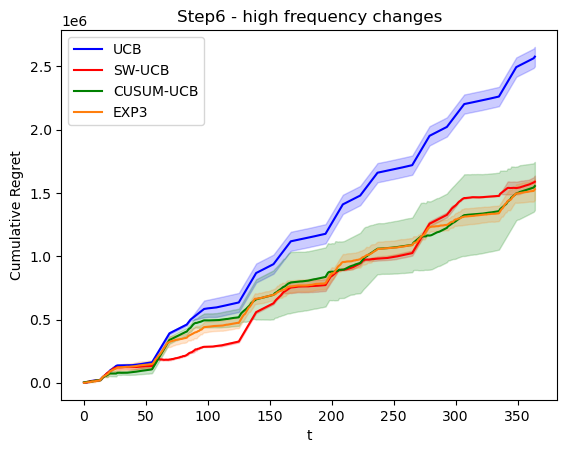

In [29]:
plt.figure(0)
plt.title("Step6 - high frequency changes")
plt.xlabel("t")
plt.ylabel("Cumulative Regret")
plt.plot(np.mean(cumregret_ucb, axis=0), 'b')
plt.plot(np.mean(cumregret_swucb, axis=0), 'r')
plt.plot(np.mean(cumregret_cusumucb, axis=0), 'g')
plt.plot(np.mean(cumregret_exp3, axis=0), 'tab:orange')
plt.fill_between(range(T), np.mean(cumregret_ucb, axis=0) - np.std(cumregret_ucb, axis=0),
                 np.mean(cumregret_ucb, axis=0) + np.std(cumregret_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_swucb, axis=0) - np.std(cumregret_swucb, axis=0),
                 np.mean(cumregret_swucb, axis=0) + np.std(cumregret_swucb, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_cusumucb, axis=0) - np.std(cumregret_cusumucb, axis=0),
                 np.mean(cumregret_cusumucb, axis=0) + np.std(cumregret_cusumucb, axis=0), color="green", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_exp3, axis=0) - np.std(cumregret_exp3, axis=0),
                 np.mean(cumregret_exp3, axis=0) + np.std(cumregret_exp3, axis=0), color="tab:orange", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB", "EXP3"])
plt.show()

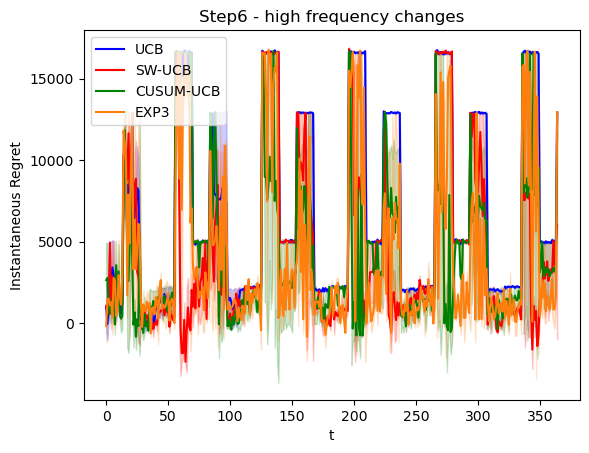

In [30]:
plt.figure(1)
plt.title("Step6 - high frequency changes")
plt.xlabel("t")
plt.ylabel("Instantaneous Regret")
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(opt - swucb_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(opt - cusumucb_rewards_per_experiment, axis=0), 'g')
plt.plot(np.mean(opt - exp3_rewards_per_experiment, axis=0), 'tab:orange')
plt.fill_between(range(T),
                 np.mean(opt - ucb_rewards_per_experiment, axis=0) - np.std(opt - ucb_rewards_per_experiment, axis=0),
                 np.mean(opt - ucb_rewards_per_experiment, axis=0) + np.std(opt - ucb_rewards_per_experiment, axis=0),
                 color="blue", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - swucb_rewards_per_experiment, axis=0) - np.std(opt - swucb_rewards_per_experiment,
                                                                              axis=0),
                 np.mean(opt - swucb_rewards_per_experiment, axis=0) + np.std(opt - swucb_rewards_per_experiment,
                                                                              axis=0), color="red", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - cusumucb_rewards_per_experiment, axis=0) - np.std(opt - cusumucb_rewards_per_experiment,
                                                                                 axis=0),
                 np.mean(opt - cusumucb_rewards_per_experiment, axis=0) + np.std(opt - cusumucb_rewards_per_experiment,
                                                                                 axis=0), color="green", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - exp3_rewards_per_experiment, axis=0) - np.std(opt - exp3_rewards_per_experiment, axis=0),
                 np.mean(opt - exp3_rewards_per_experiment, axis=0) + np.std(opt - exp3_rewards_per_experiment, axis=0),
                 color="tab:orange", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB", "EXP3"])
plt.show()

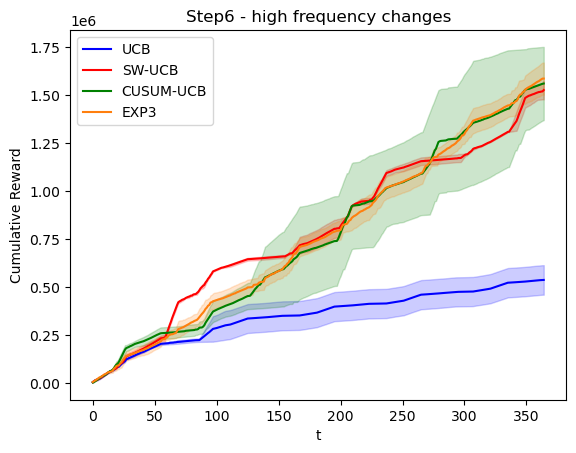

In [31]:
plt.figure(2)
plt.title("Step6 - high frequency changes")
plt.xlabel("t")
plt.ylabel("Cumulative Reward")
plt.plot(np.mean(cumreward_ucb, axis=0), 'b')
plt.plot(np.mean(cumreward_swucb, axis=0), 'r')
plt.plot(np.mean(cumreward_cusumucb, axis=0), 'g')
plt.plot(np.mean(cumreward_exp3, axis=0), 'tab:orange')
plt.fill_between(range(T), np.mean(cumreward_ucb, axis=0) - np.std(cumreward_ucb, axis=0),
                 np.mean(cumreward_ucb, axis=0) + np.std(cumreward_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_swucb, axis=0) - np.std(cumreward_swucb, axis=0),
                 np.mean(cumreward_swucb, axis=0) + np.std(cumreward_swucb, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_cusumucb, axis=0) - np.std(cumreward_cusumucb, axis=0),
                 np.mean(cumreward_cusumucb, axis=0) + np.std(cumreward_cusumucb, axis=0), color="green", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_exp3, axis=0) - np.std(cumreward_exp3, axis=0),
                 np.mean(cumreward_exp3, axis=0) + np.std(cumreward_exp3, axis=0), color="tab:orange", alpha=0.2)
plt.legend(["UCB", "SW-UCB", "CUSUM-UCB", "EXP3"])
plt.show()

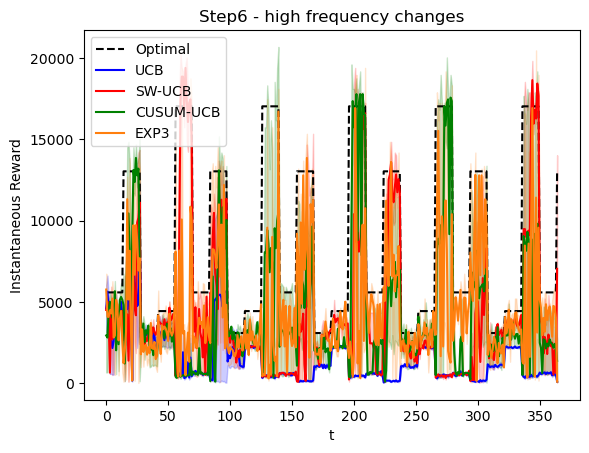

In [32]:
plt.figure(3)
plt.title("Step6 - high frequency changes")
plt.xlabel("t")
plt.ylabel("Instantaneous Reward")
plt.plot(opt, 'k--')
plt.plot(np.mean(ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(swucb_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(cusumucb_rewards_per_experiment, axis=0), 'g')
plt.plot(np.mean(exp3_rewards_per_experiment, axis=0), 'tab:orange')
plt.fill_between(range(T), np.mean(ucb_rewards_per_experiment, axis=0) - np.std(ucb_rewards_per_experiment, axis=0),
                 np.mean(ucb_rewards_per_experiment, axis=0) + np.std(ucb_rewards_per_experiment, axis=0), color="blue",
                 alpha=0.2)
plt.fill_between(range(T), np.mean(swucb_rewards_per_experiment, axis=0) - np.std(swucb_rewards_per_experiment, axis=0),
                 np.mean(swucb_rewards_per_experiment, axis=0) + np.std(swucb_rewards_per_experiment, axis=0),
                 color="red", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(cusumucb_rewards_per_experiment, axis=0) - np.std(cusumucb_rewards_per_experiment, axis=0),
                 np.mean(cusumucb_rewards_per_experiment, axis=0) + np.std(cusumucb_rewards_per_experiment, axis=0),
                 color="green", alpha=0.2)
plt.fill_between(range(T), np.mean(exp3_rewards_per_experiment, axis=0) - np.std(exp3_rewards_per_experiment, axis=0),
                 np.mean(exp3_rewards_per_experiment, axis=0) + np.std(exp3_rewards_per_experiment, axis=0),
                 color="tab:orange", alpha=0.2)
plt.legend(["Optimal", "UCB", "SW-UCB", "CUSUM-UCB", "EXP3"])
plt.show()

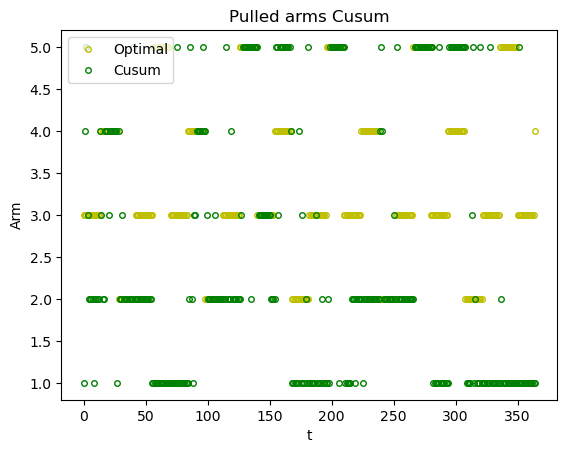

In [33]:
plt.figure(4)
plt.title("Pulled arms Cusum")
plt.xlabel("t")
plt.ylabel("Arm")
plt.plot(np.array(opt_arm) + 1, marker='o', markerfacecolor='None', markeredgecolor='y', markersize=4, linestyle='None')
plt.plot(np.array(pulled_arms_cusum[-1]) + 1, marker='o', markerfacecolor='None', markeredgecolor='g', markersize=4, linestyle='None')
plt.legend(["Optimal", "Cusum"])
plt.show()

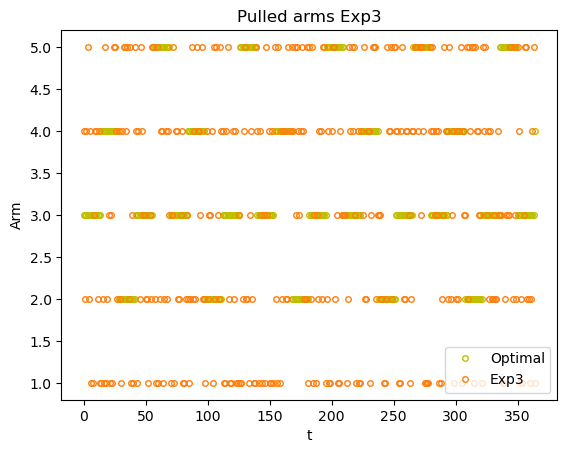

In [34]:
plt.figure(5)
plt.title("Pulled arms Exp3")
plt.xlabel("t")
plt.ylabel("Arm")
plt.plot(np.array(opt_arm) + 1, marker='o', markerfacecolor='None', markeredgecolor='y', markersize=4, linestyle='None')
plt.plot(np.array(pulled_arms_exp3[-1]) + 1, marker='o', markerfacecolor='None', markeredgecolor='tab:orange', markersize=4, linestyle='None')
plt.legend(["Optimal", "Exp3"])
plt.show()

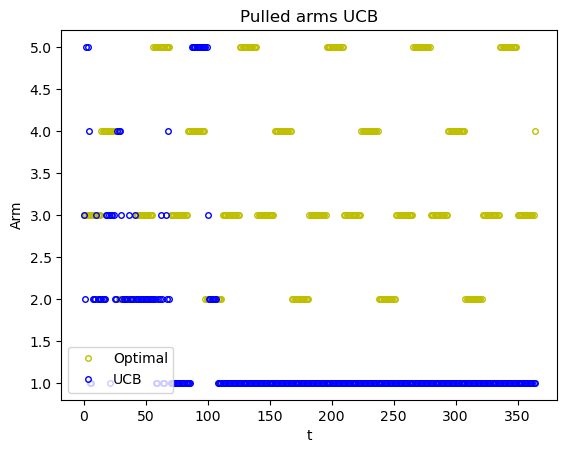

In [35]:
plt.figure(6)
plt.title("Pulled arms UCB")
plt.xlabel("t")
plt.ylabel("Arm")
plt.plot(np.array(opt_arm) + 1, marker='o', markerfacecolor='None', markeredgecolor='y', markersize=4, linestyle='None')
plt.plot(np.array(pulled_arms_ucb[-1]) + 1, marker='o', markerfacecolor='None', markeredgecolor='b', markersize=4, linestyle='None')
plt.legend(["Optimal", "UCB"])
plt.show()

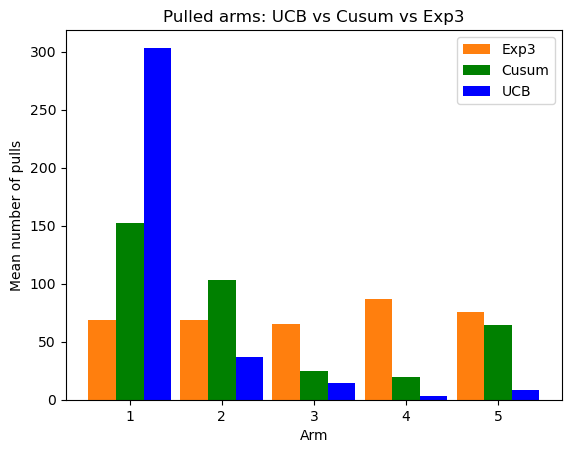

In [36]:
mean_pulls_per_arm_exp3 = np.zeros(n_arms)
mean_pulls_per_arm_cusum = np.zeros(n_arms)
mean_pulls_per_arm_ucb = np.zeros(n_arms)
for e in range(n_experiments):
    for arm in range(n_arms):
        mean_pulls_per_arm_exp3[arm] += np.sum(np.array(pulled_arms_exp3[e]) == arm) / n_experiments
        mean_pulls_per_arm_cusum[arm] += np.sum(np.array(pulled_arms_cusum[e]) == arm) / n_experiments
        mean_pulls_per_arm_ucb[arm] += np.sum(np.array(pulled_arms_ucb[e]) == arm) / n_experiments

barWidth = 0.3
br1 = np.arange(n_arms)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
plt.figure(7)
plt.title("Pulled arms: UCB vs Cusum vs Exp3")
plt.bar(br1, mean_pulls_per_arm_exp3, color='tab:orange', width=barWidth)
plt.bar(br2, mean_pulls_per_arm_cusum, color='g', width=barWidth)
plt.bar(br3, mean_pulls_per_arm_ucb, color='b', width=barWidth)
plt.ylabel("Mean number of pulls")
plt.xlabel("Arm")
plt.xticks([r + barWidth for r in range(n_arms)], np.array(range(n_arms)) + 1)
plt.legend(["Exp3", "Cusum", "UCB"])
plt.show()